## 1. Load data from file

In [0]:
import numpy as np
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_PATH = './mnist.csv'
SIZE_ROW = 28
SIZE_COL = 28

# load data from file
data = torch.from_numpy(
    np.genfromtxt(DATA_PATH, delimiter=',')
)

# separate pixel values from labels
X_raw = data[:, 1:]
Y_raw = data[:, 0]

## 2. Data preprocessing

In [0]:
# normalize X data
X_data = (X_raw - torch.min(X_raw)) / (torch.max(X_raw) - torch.min(X_raw))

# one-hot encoding Y data
Y_data = Y_raw.to(torch.long)
Y_data = torch.eye(torch.unique(Y_data).shape[0])[Y_data]

# train data
X_train = X_data[:6000].to(device)
Y_train = Y_data[:6000].to(device)

# test data
X_test = X_data[6000:].to(device)
Y_test = Y_data[6000:].to(device)

## 3. Define model and functions for learning neural network

In [0]:
import math

def initialize_weights(fan_in, fan_out):
    return math.sqrt(1 / fan_in) * torch.randn(fan_out, fan_in)

def activation(z):
  return 1 / (1 + torch.exp(-z))

def objective(Y_pred, Y):
  epsilon = 1e-8
  return (-1 / Y.shape[0]) * torch.sum(
      Y * torch.log(Y_pred + epsilon) + (1 - Y) * torch.log(1 - Y_pred + epsilon)
  )

def accuracy(Y_pred, Y):
  answer_Y_pred = torch.argmax(Y_pred, axis=1)
  answer_Y = torch.argmax(Y, axis=1)
  return torch.mean((answer_Y_pred == answer_Y).float())


class ThreeLayerNN:
  def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    self.params = dict()
    self.forwards = dict()
    self.grads = dict()

    self.params['w1'] = initialize_weights(input_size, hidden1_size).double().to(device)
    self.params['b1'] = torch.zeros(1, hidden1_size).double().to(device)

    self.params['w2'] = initialize_weights(hidden1_size, hidden2_size).double().to(device)
    self.params['b2'] = torch.zeros(1, hidden2_size).double().to(device)

    self.params['w3'] = initialize_weights(hidden2_size, output_size).double().to(device)
    self.params['b3'] = torch.zeros(1, output_size).double().to(device)
    
  def forward(self, X):
    w1, w2, w3 = self.params['w1'], self.params['w2'], self.params['w3']
    b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']

    z1 = torch.matmul(X, w1.T) + b1
    a1 = activation(z1)

    z2 = torch.matmul(a1, w2.T) + b2
    a2 = activation(z2)

    z3 = torch.matmul(a2, w3.T) + b3
    a3 = activation(z3)

    forward_results = dict()
    forward_results['z1'], forward_results['z2'], forward_results['z3'] = z1, z2, z3
    forward_results['a1'], forward_results['a2'], forward_results['a3'] = a1, a2, a3

    return forward_results

  def backward(self, X, Y, forward_results):
    w1, w2, w3 = self.params['w1'], self.params['w2'], self.params['w3']
    b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']

    z1, z2, z3 = forward_results['z1'], forward_results['z2'], forward_results['z3']
    a1, a2, a3 = forward_results['a1'], forward_results['a2'], forward_results['a3']

    dz3 = (a3 - Y) / X.shape[0]

    da2 = torch.matmul(dz3, w3)
    dz2 = a2 * (1 - a2) * da2

    da1 = torch.matmul(dz2, w2)
    dz1 = a1 * (1 - a1) * da1

    dw3 = torch.matmul(dz3.T, a2)
    db3 = torch.sum(dz3, axis=0).reshape(1, -1)

    dw2 = torch.matmul(dz2.T, a1)
    db2 = torch.sum(dz2, axis=0).reshape(1, -1)

    dw1 = torch.matmul(dz1.T, X)
    db1 = torch.sum(dz1, axis=0).reshape(1, -1)

    self.grads['w1'], self.grads['w2'], self.grads['w3'] = dw1, dw2, dw3
    self.grads['b1'], self.grads['b2'], self.grads['b3'] = db1, db2, db3

## 4. Learning with the gradient descent algorithm


In [0]:
lr = 0.7
epoch_count = 1000
nn = ThreeLayerNN(784, 196, 49, 10)

history = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': []
}

for epoch in range(epoch_count):
  # forward propagation using train data
  train_forward_results = nn.forward(X_train)

  # calculate training loss and accuracy
  Y_train_pred = train_forward_results['a3']
  train_loss = objective(Y_train_pred, Y_train)
  train_acc = accuracy(Y_train_pred, Y_train)

  # forward propagation using test data
  test_forward_results = nn.forward(X_test)

  # calculate testing loss and accuracy
  Y_test_pred = test_forward_results['a3']
  test_loss = objective(Y_test_pred, Y_test)
  test_acc = accuracy(Y_test_pred, Y_test)

  # log history
  history['train_loss'].append(train_loss.item())
  history['test_loss'].append(test_loss.item())
  history['train_acc'].append(train_acc.item())
  history['test_acc'].append(test_acc.item())

  # gradient descent
  nn.backward(X_train, Y_train, train_forward_results)
  for key in nn.params.keys():
    nn.params[key] -= lr * nn.grads[key]

# convert list to numpy array
for key in history.keys():
  history[key] = np.array(history[key])

## 5. Results


### 5-1. Plot the loss curve

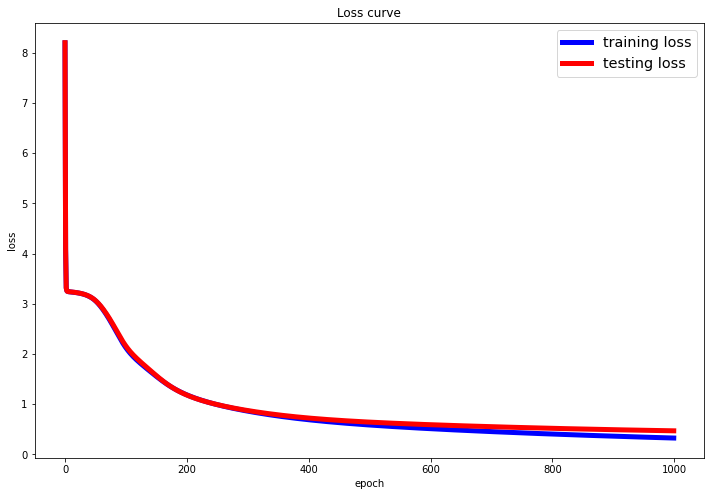

In [10]:
import matplotlib.pyplot as plt

epoch_tick = np.arange(epoch_count)

plt.figure(figsize=(12, 8))
plt.title('Loss curve')
plt.plot(epoch_tick, history['train_loss'], 'b-', linewidth=5)
plt.plot(epoch_tick, history['test_loss'], 'r-', linewidth=5)
plt.legend(['training loss', 'testing loss'], fontsize='x-large', loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 5-2. Plot the accuracy curve

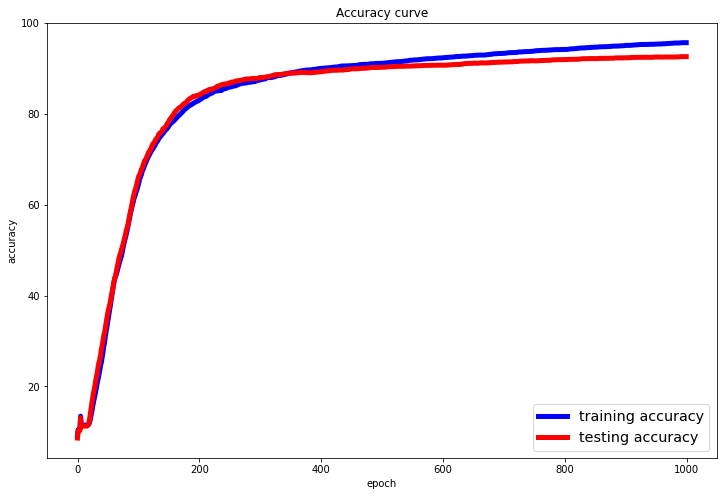

In [11]:
plt.figure(figsize=(12, 8))
plt.title('Accuracy curve')
plt.plot(epoch_tick, history['train_acc'] * 100, 'b-', linewidth=5)
plt.plot(epoch_tick, history['test_acc'] * 100, 'r-', linewidth=5)
plt.legend(['training accuracy', 'testing accuracy'], fontsize='x-large', loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### 5-3. Plot the accuracy value

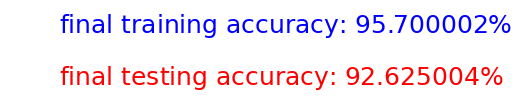

In [23]:
final_train_acc = round(history['train_acc'][-1] * 100, 6)
final_test_acc = round(history['test_acc'][-1] * 100, 6)

ax = plt.axes([0, 0, 0.6, 0.3])
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.text(0.2, 0.7, f'final training accuracy: ${final_train_acc}$%', size=25, color='blue')
plt.text(0.2, 0.1, f'final testing accuracy: ${final_test_acc}$%', size=25, color='red')
plt.show()